**Step 1 - Import Libraries**

In [27]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_curve, auc
)

**STEP 2 — Load the dataset**

In [28]:
df = pd.read_csv("spam.csv", encoding="latin1")
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**STEP 3 --Detect Target Column (Price)**

In [29]:
# Inspect columns and guess text + label columns.
# Common spam datasets: label in 'v1' or 'label'/'type', text in 'v2' or 'message'/'text'
possible_label_names = {"v1", "label", "type", "class", "target"}
possible_text_names = {"v2", "message", "text", "msg", "body"}

label_col = None
text_col = None

# find label column (categorical/object with few unique values)
for c in df.columns:
    if c in possible_label_names:
        label_col = c
        break

if label_col is None:
    # fallback: choose object dtype column with <= 10 unique values
    for c in df.columns:
        if df[c].dtype == object and df[c].nunique() <= 10:
            label_col = c
            break

# find text column
for c in df.columns:
    if c in possible_text_names:
        text_col = c
        break

if text_col is None:
    # fallback: choose the longest text/object column
    object_cols = [c for c in df.columns if df[c].dtype == object and c != label_col]
    if object_cols:
        # pick column with largest average string length
        avg_len = {c: df[c].astype(str).map(len).mean() for c in object_cols}
        text_col = max(avg_len, key=avg_len.get)

if label_col is None or text_col is None:
    raise ValueError(f"Could not auto-detect label/text columns. Found label_col={label_col}, text_col={text_col}")

print("Detected label column:", label_col)
print("Detected text column:", text_col)

Detected label column: v1
Detected text column: v2


**STEP 4 --Basic Cleaning & Feature Separation**

In [30]:
# Keep only relevant columns and drop NaNs in text or label
df = df[[label_col, text_col]].dropna().copy()
df[text_col] = df[text_col].astype(str)

# ---------------------------
# Basic text preprocessing
# ---------------------------
def clean_text(s):
    s = s.lower()
    # remove URLs, emails, numbers and punctuation (simple)
    s = re.sub(r'http\S+|www\.\S+', ' ', s)
    s = re.sub(r'\S+@\S+', ' ', s)
    s = re.sub(r'\d+', ' ', s)
    s = re.sub(r'[^a-z\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df["text_clean"] = df[text_col].map(clean_text)

# ---------------------------
# Encode labels (binary)
# ---------------------------
le = LabelEncoder()
y = le.fit_transform(df[label_col].values)
class_names = list(le.classes_)
print("Classes (encoded):", list(enumerate(class_names)))

X_text = df["text_clean"].values

# ---------------------------
# Vectorize (TF-IDF)
# ---------------------------
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")
X = tfidf.fit_transform(X_text)

# ---------------------------
# Train-test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



Classes (encoded): [(0, 'ham'), (1, 'spam')]


**STEP 5 -- TRAIN THE MODEL**

In [31]:

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, solver="liblinear"),
    "MultinomialNB": MultinomialNB(),
    "SVC": SVC(probability=True)  # probability=True needed for ROC
}

trained = {}
results = {}

for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    trained[name] = model
    results[name] = {
        "accuracy": acc,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "classification_report": report,
        "confusion_matrix": cm
    }

    print(f"Accuracy: {acc:.4f}")
    print("Classification report:\n", report)
    print("Confusion matrix:\n", cm)




Training LogisticRegression ...
Accuracy: 0.9596
Classification report:
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.99      0.70      0.82       149

    accuracy                           0.96      1115
   macro avg       0.97      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115

Confusion matrix:
 [[965   1]
 [ 44 105]]

Training MultinomialNB ...
Accuracy: 0.9686
Classification report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       0.99      0.77      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Confusion matrix:
 [[965   1]
 [ 34 115]]

Training SVC ...
Accuracy: 0.9776
Classification report:
               precision    recall  f1-score   support

     

**STEP 6 -- BEST MODEL**

In [32]:

best_name = max(results.items(), key=lambda kv: kv[1]["accuracy"])[0]
best_model = trained[best_name]
print(f"\nBest model by test accuracy: {best_name}")



Best model by test accuracy: SVC


**1) Class distribution**

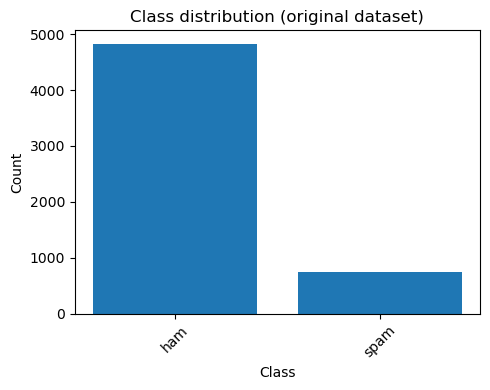

In [33]:

plt.figure(figsize=(5,4))
labels, counts = np.unique(df[label_col].values, return_counts=True)
plt.bar(labels, counts)
plt.title("Class distribution (original dataset)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**2) Message length histogram (spam vs ham)**

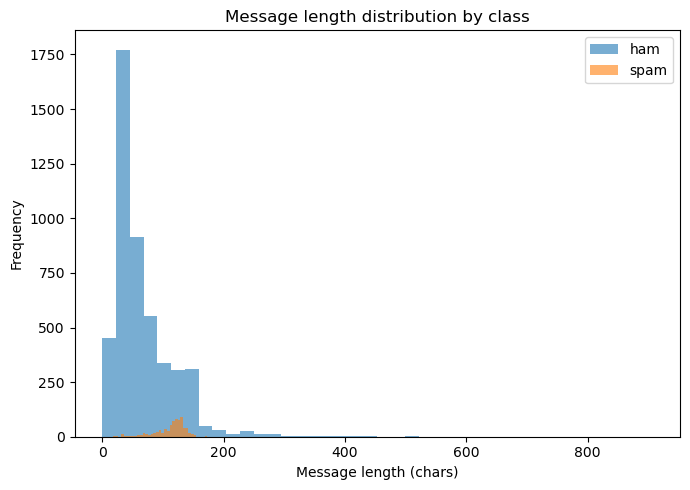

In [34]:
if "text_clean" not in df.columns:
    df["text_clean"] = df[text_col].astype(str).map(lambda s: s.lower())

df["msg_len"] = df["text_clean"].map(len)
# original label column values (not encoded)
orig_labels = df[label_col].values

plt.figure(figsize=(7,5))
for lbl in np.unique(orig_labels):
    plt.hist(df.loc[df[label_col] == lbl, "msg_len"], bins=40, alpha=0.6, label=str(lbl))
plt.xlabel("Message length (chars)")
plt.ylabel("Frequency")
plt.title("Message length distribution by class")
plt.legend()
plt.tight_layout()
plt.show()


**Confusion matrix plot (best model)**

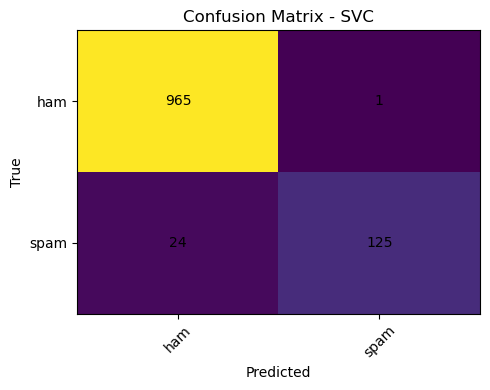

In [35]:

cm = results[best_name]["confusion_matrix"]
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest", aspect="auto")
plt.title(f"Confusion Matrix - {best_name}")
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i, j]), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


**Precision-Recall curve(s)**

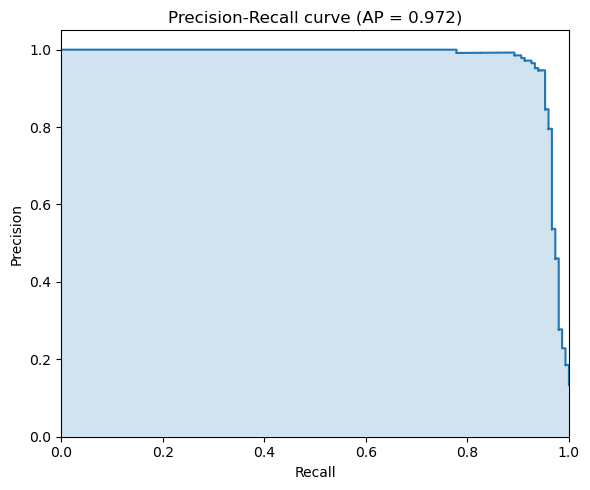

In [23]:

from sklearn.metrics import precision_recall_curve, average_precision_score
if len(class_names) == 2:
    # binary PR curve
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        y_score = best_model.decision_function(X_test)
    else:
        y_score = None

    if y_score is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        ap = average_precision_score(y_test, y_score)
        plt.figure(figsize=(6,5))
        plt.step(recall, precision, where="post")
        plt.fill_between(recall, precision, step="post", alpha=0.2)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall curve (AP = {ap:.3f})")
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.tight_layout()
        plt.show()
    else:
        print("No probability or decision_function scores; cannot plot PR curve.")
else:
    # multi-class PR curves (one-vs-rest)
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test)
        y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
        plt.figure(figsize=(7,6))
        for i in range(len(class_names)):
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
            ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
            plt.step(recall, precision, where="post", label=f"{class_names[i]} (AP={ap:.2f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall (One-vs-Rest)")
        plt.legend(loc="best", fontsize="small")
        plt.tight_layout()
        plt.show()
    else:
        print("Best model lacks predict_proba; skipping multiclass PR curves.")


**# ROC Curve (binary) for best model**

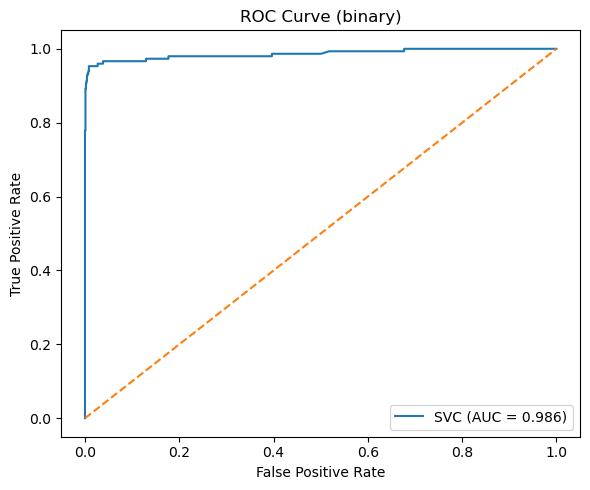

In [17]:

# Ensure binary classification
n_classes = len(class_names)
if n_classes == 2:
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        y_score = best_model.decision_function(X_test)
    else:
        y_score = None

    if y_score is not None:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"{best_name} (AUC = {roc_auc:.3f})")
        plt.plot([0,1], [0,1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (binary)")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    else:
        print("Best model does not provide scores for ROC plotting.")
else:
    print("Multiclass ROC not plotted (dataset appears to have >2 classes).")